# Test free space using segmentation result and ransac algorithm


This small example shows the relationship between the world coordinates $[x, y, z]$ and the projected image coordinates $[u, v]$ depending on the values in the camera matrix $A$.

$$u = f_x\frac{x}{z} + p_x$$

$$v = f_y\frac{-y}{z} + p_y$$

$$A = \begin{bmatrix} f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1 \end{bmatrix}$$

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras
from keras.models import load_model
# from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import math

%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils
import helpers

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils


In [2]:
cam_mtx = np.array([
    [358.5, 0.0,   512.0],
    [0.0,   358.5, 256.0],
    [0.0,   0.0,   1.0],
    
])
# x = (u-px)*z/f
# y = (-v+py)*z/f
# z = depth

semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 

In [3]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/test_prof_data_latest.h5')
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')

In [30]:
# path_test = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/rgb_img.jpg'
# depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/depth_img.png'
# label_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/label_img.png'

path_test = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/rgb_img_1.jpg'
depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/depth_img_1.png'
label_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/label_img_1.png'

#-------------------------------------------------------------------------------------------------------------------
img_test = cv2.imread(path_test)
label_img = cv2.imread(label_path)
img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
depth_img = cv2.imread(depth_path,-1)
depth_img = depth_img/100.0

In [5]:
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)

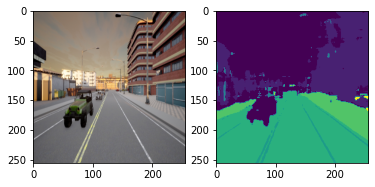

In [31]:
predicted_img = cv2.resize(img_test,(256,256))

getshape = predicted_img.shape
pred = model.predict(predicted_img.reshape(1,getshape[0],getshape[1],getshape[2]))

#print(pred.shape)        
predicted_mask = np.zeros((256,256))
#print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.4:
                predicted_mask[j,k] = i
# newimg = helpers.colour_code_segmentation(newimg,label_values)
plotter(predicted_img,predicted_mask)

In [32]:
predicted_mask.astype('float32')

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.]], dtype=float32)

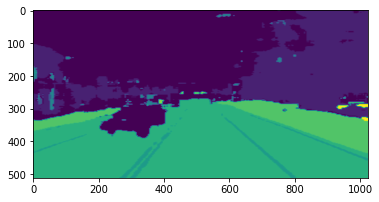

In [33]:
predicted_mask_resize = cv2.resize(predicted_mask,(1024,512,))
plt.imshow(predicted_mask_resize)

In [34]:
mask_gound = np.float32(helpers.one_hot_it(label_img,label_values))
mask_gound = helpers.reverse_one_hot(mask_gound)

In [10]:
def xy_from_depth(depth_img,cam_matrix):
    # Get the shape of the depth tensor
    H,W = depth_img.shape
    # Grab required parameters from the cam matrix
    f = cam_matrix[0,0]
    px = cam_matrix[0,2]
    py = cam_matrix[1,2]
    # Generate a grid of coordinates corresponding to the shape of the depth image
    nx, ny = (H, W)
    xa = np.arange(1, W+1, 1)
    ya = np.arange(1, H+1, 1)
    u, v = np.meshgrid(xa, ya)
    # Compute x and y coordinates
    x = (u - px)*depth_img/f
    y = (-v + py)*depth_img/f
    return x,y

In [35]:
x,y = xy_from_depth(depth_img,cam_matrix=cam_mtx)

Extract the pixels belonging to the road

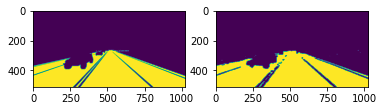

In [36]:
# Ground truth for road 
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(mask_gound.shape)
road_mask[mask_gound == 7] = 1

# Show road mask
# plt.imshow(road_mask)

# Get x,y, and z coordinates of pixels in road mask
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = depth_img[road_mask == 1]
xyz_ground = np.stack((x_ground, y_ground, z_ground))



#------------------------------------------------------------------------
# Predicted road
# Get road mask by choosing pixels in segmentation output with value 7
road_mask_predicted = np.zeros(predicted_mask_resize.shape)
road_mask_predicted[predicted_mask_resize == 7] = 1

# Show road mask
# plt.imshow(road_mask_predicted)

# Get x,y, and z coordinates of pixels in road mask
x_ground_predicted = x[road_mask_predicted == 1]
y_ground_predicted = y[road_mask_predicted == 1]
z_ground_predicted = depth_img[road_mask_predicted == 1]
xyz_ground_predicted = np.stack((x_ground_predicted, y_ground_predicted, z_ground_predicted))

plotter(road_mask,road_mask_predicted)

In [14]:
def compute_plane(xyz):
    """
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0
    Arguments:
    xyz -- tensor of dimension (3, N), contains points needed to fit plane.
    k -- tensor of dimension (3x3), the intrinsic camera matrix
    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a,b,c,d
    """
    ctr = xyz.mean(axis=1)
    normalized = xyz - ctr[:, np.newaxis]
    M = np.dot(normalized, normalized.T)

    p = np.linalg.svd(M)[0][:, -1]
    d = np.matmul(p, ctr)

    p = np.append(p, -d)

    # Correct plane
    # p = [0.0, 1.0, 0.0, -1.5]
    return p


def dist_to_plane(plane, x, y, z):
    """
    Computes distance between points provided by their x, and y, z coordinates
    and a plane in the form ax+by+cz+d = 0
    Arguments:
    plane -- tensor of dimension (4,1), containing the plane parameters [a,b,c,d]
    x -- tensor of dimension (HxW), containing the x coordinates of the points
    y -- tensor of dimension (HxW), containing the y coordinates of the points
    z -- tensor of dimension (HxW), containing the z coordinates of the points
    Returns:
    distance -- tensor of dimension (H, W) containing the distance between points and the plane
    """
    a, b, c, d = plane

    return (a * x + b * y + c * z + d) / np.sqrt(a**2 + b**2 + c**2)


def get_slope_intecept(lines):
    slopes = (lines[:, 3] - lines[:, 1]) / (lines[:, 2] - lines[:, 0] + 0.001)
    intercepts = ((lines[:, 3] + lines[:, 1]) - slopes * (
        lines[:, 2] + lines[:, 0])) / 2
    return slopes, intercepts


def extrapolate_lines(lines, y_min, y_max):
    slopes, intercepts = get_slope_intecept(lines)

    new_lines = []

    for slope, intercept, in zip(slopes, intercepts):
        x1 = (y_min - intercept) / slope
        x2 = (y_max - intercept) / slope
        new_lines.append([x1, y_min, x2, y_max])

    return np.array(new_lines)


def find_closest_lines(lines, point):
    x0, y0 = point
    distances = []
    for line in lines:
        x1, y1, x2, y2 = line
        distances.append(((x2 - x1) * (y1 - y0) - (x1 - x0) *
                          (y2 - y1)) / (np.sqrt((y2 - y1)**2 + (x2 - x1)**2)))

    distances = np.abs(np.array(distances))
    sorted = distances.argsort()

    return lines[sorted[0:2], :]

//TODO
1. Choose a minimum of 3 points from xyz_ground at random.

2. Compute the ground plane model using the chosen random points

3. Compute the distance from the ground plane model to every point in xyz_ground, and compute the number of inliers based on a distance threshold.

4. Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.

5. Repeat until number of iterations $\geq$ a preset number of iterations, or number of inliers $\geq$ minimum number of inliers.

6. Recompute and return a plane model using all inliers in the final inlier set.

In [15]:
def ransac_plane_fit(xyz_ground):
  # set threshold for ransac algorithm
  num_itr = 1000  # RANSAC maximum number of iterations
  min_num_inliers = 200000 # RANSAC minimum number of inliers
  distance_threshold = 0.00001  # Maximum distance from point to plane for point to be considered inlier
  N = xyz_ground.shape[1]
  inlineC_temp = []
  CCC_temp = np.zeros((3,4))
  for i in range(num_itr):
    # 1: choose a minimum of 3 points from xyz ground plane
    ac = np.random.choice(N,6)
    CCC = (np.vstack((xyz_ground.T[ac[0]],xyz_ground.T[ac[1]],xyz_ground.T[ac[2]],
                      xyz_ground.T[ac[3]],xyz_ground.T[ac[4]],xyz_ground.T[ac[5]]))).T
    # 2: compute plane model
    p = compute_plane(CCC)
    # 3: Find number of inliers
    bc = np.random.choice(N,150)
    xx=[]
    yy=[]
    zz=[]
       
    xx = np.array(xyz_ground[0,0:]).T
    yy = np.array(xyz_ground[1,0:]).T
    zz = np.array(xyz_ground[2,0:]).T
    dis = dist_to_plane(p,xx,yy,zz)
    # 4: Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.
    inlinec = np.zeros(dis.shape)
    inlinec[dis < distance_threshold] = 1
    # print(sum(inlinec))
    if sum(inlinec) > sum(inlineC_temp):
      CCC_temp = CCC

    # 5: Check if stopping criterion is satisfied and break.         
    if sum(inlinec) >= min_num_inliers:
      return p
        
  # 6: Recompute the model parameters using largest inlier set.
  p = compute_plane(CCC_temp)

  return p

In [37]:
# Predicted ground plane
p_final = ransac_plane_fit(xyz_ground_predicted)
print('Ground Plane: ' + str(p_final))

Ground Plane: [-2.63181977e-04  9.99898124e-01  1.42713999e-02  2.00975943e+00]


find the truth ground mask

In [38]:
# True ground plane
p_final_groundTruth = ransac_plane_fit(xyz_ground)
print('Ground Plane: ' + str(p_final_groundTruth))

Ground Plane: [-3.11511660e-04  9.99896032e-01  1.44162230e-02  2.00950084e+00]


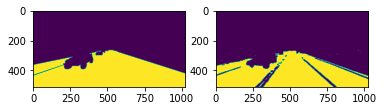

In [54]:
dist = np.abs(dist_to_plane(p_final, x, y, depth_img))

ground_mask_predicted = np.zeros(dist.shape)

ground_mask_predicted[dist < 0.05] = 1
ground_mask_predicted[dist > 0.05] = 0

plotter(ground_mask_predicted,road_mask_predicted)

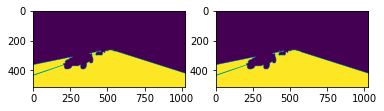

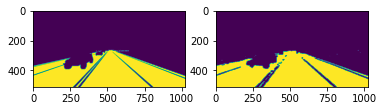

In [55]:
dist_groundTruth = np.abs(dist_to_plane(p_final_groundTruth, x, y, depth_img))

ground_mask_truth = np.zeros(dist_groundTruth.shape)

ground_mask_truth[dist_groundTruth < 0.05] = 1
ground_mask_truth[dist_groundTruth > 0.05] = 0

# print('Ground mask truth and predicted')

plotter(ground_mask_truth,ground_mask_predicted)

plotter(road_mask,road_mask_predicted)
# print('Road mask truth and predicted')

In [20]:
from sklearn.metrics import confusion_matrix  
#  import numpy as np

def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [56]:
meanIoU = compute_iou(ground_mask_truth,ground_mask_predicted)

Mean IoU = 0.9994797653334528


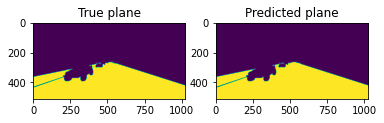

In [57]:
plt.subplot(1,2,1)
plt.title('True plane')
plt.imshow(ground_mask_truth)
plt.subplot(1,2,2)
plt.title('Predicted plane')
plt.imshow(ground_mask_predicted)

print(f'Mean IoU = {meanIoU}')

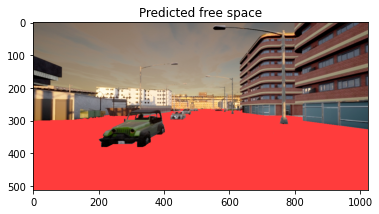

In [58]:
img_filled_mask = img_test
img_filled_mask[ground_mask_predicted==1] = (255,60,60) 
plt.title('Predicted free space')
plt.imshow(img_filled_mask)

# Drivable space

In [49]:
def free_space(depth, segmentation,cam_mtx):

      sz = depth.shape
      f = cam_mtx[0, 0]
      c_u = cam_mtx[0, 2]

      # Generate a grid of coordinates corresponding to the shape of the depth
      # map
      u, v = np.meshgrid(np.arange(1, sz[1] + 1, 1),
                         np.arange(1, sz[0] + 1, 1))

      # Compute x and y coordinates
      xx = ((u - c_u) * depth) / f

      xx = xx * 10 + 200  #200
      xx = np.maximum(0, np.minimum(xx, 399))#399

      depth = depth * 10
      depth[depth > 300] = np.nan #300

      occ_grid = np.full([301, 401], 0.5) # occupancy grid

      for x, z, seg in zip(xx.flatten('C'), depth.flatten('C'),
                           segmentation.flatten('C')):
          if not(seg == 1):
              if not np.isnan(x) and not np.isnan(z):
                  x = int(x)
                  z = int(z)
                  occ_grid[z, x] = 1

      for x, z, seg in zip(xx.flatten('C'), depth.flatten('C'),
                           segmentation.flatten('C')):
          if seg == 1:
              if not np.isnan(x) and not np.isnan(z):
                  x = int(x)
                  z = int(z)
                  if not occ_grid[z, x] == 1:
                      occ_grid[z, x] = 0

      # fig, ax = plt.subplots(nrows=1, ncols=1)
      # ax.imshow(occ_grid)#, cmap='Greys')

      # labels = ax.get_xticks()
      # labels = [str((label - 200) / 10.0) for label in labels]
      # ax.set_xticklabels(labels)

      # labels = ax.get_yticks()
      # labels = [str(label / 10.0) for label in labels]
      # ax.set_yticklabels(labels)

      # ax.invert_yaxis()
      # plt.show()
      return occ_grid

Estimated drivable space in 3D

In [51]:
drivable_space = free_space(depth_img,ground_mask_predicted,cam_mtx)

(301, 401)

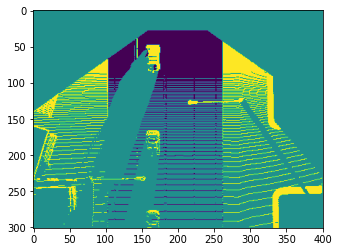

In [52]:
plt.imshow(drivable_space)
# drivable_space.shape